In [1]:
import glob
import numpy as np
import pylab as pl
from scipy import misc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load images

In [2]:
def constructFilenames(data_dir):
    """
    Returns generated filenames for every English letter.
    """
    filenames = []
    for letter_id in xrange(26):
        filenames_of_letter = []
        filenames_of_letter.append(data_dir + 'class-' + str(letter_id) + '.bmp')
        for f in glob.glob(data_dir + 'mutant-' + str(letter_id) + '-*-*.bmp'):
            filenames_of_letter.append(f)
        filenames.append(filenames_of_letter)
    return filenames

def loadData(filenames):
    """
    Returns images (as arrays of greyscale values) and corresponding labels.
    """
    n_letters = len(filenames)
    all_images = []
    all_labels = []
    for i, letter_files in enumerate(filenames):
        images_of_letter = []
        label = np.zeros(n_letters)
        label[i] = 1
        for f in letter_files:
            image = misc.imread(f, flatten=True)
            images_of_letter.append([pixel / 255.0 for pixel in image.flatten()])
        all_images.append(np.asarray(images_of_letter))
        all_labels.append([label] * len(letter_files))
    return np.asarray(all_images), np.asarray(all_labels)

filenames = constructFilenames('../big_alphabet_29x29/')
X, Y = loadData(filenames)

# Create train, test and validation sets

In [3]:
def ThreeFolds(X, Y, train_size=None, test_size=None, cv_size=None):
    """
    Divide X and Y into train, test and validation sets.
    """
    if train_size and test_size:
        cv_size = 1 - train_size - test_size
    elif train_size and cv_size:
        test_size = 1 - train_size - cv_size
    elif test_size and cv_size:
        train_size = 1 - test_size - cv_size
    else:
        raise ValueError('Not enough parameters for function')

    all_samples = np.arange(X.shape[1])
    N = len(all_samples)
    train = np.random.choice(all_samples, int(train_size * N), replace=False)
    all_samples = np.setdiff1d(all_samples, train)
    test = np.random.choice(all_samples, int(test_size * N), replace=False)
    cv = np.setdiff1d(all_samples, test)

    X_train, X_test, X_cv = X[:, train].reshape((-1, X.shape[2])), \
                            X[:, test].reshape((-1, X.shape[2])), \
                            X[:, cv].reshape((-1, X.shape[2]))
    Y_train, Y_test, Y_cv = Y[:, train].reshape((-1, Y.shape[2])), \
                            Y[:, test].reshape((-1, Y.shape[2])), \
                            Y[:, cv].reshape((-1, Y.shape[2]))
    return [X_train, Y_train], [X_test, Y_test], [X_cv, Y_cv]

train, test, cv = ThreeFolds(X, Y, train_size=0.6, test_size=0.2)

# Helper functions

In [4]:
##### Activation functions #########################

def sigmoid(z, a=1.0):
    """
    :param z: input value
    :return:  sigmoid function
    """
    return 1 / (1 + np.exp(-a * z))

def d_sigmoid(z, a=1.0):
    """
    :param z: input value
    :return:  derivative of sigmoid
    """
    s = sigmoid(z, a)
    return a * s * (1 - s)

##### Cost functions ###############################

def xeuclidian(t, y):
    """
    :param t: true values
    :param y: predicted values
    :return:  half of squared Euclidian distance
    """
    return np.sum((t - y) ** 2, axis=1) / 2.0

def d_xeuclidian(t, y):
    """
    :param t: true values
    :param y: predicted values
    :return:  derivative of xeuclidian
    """
    return y - t

@np.vectorize
def loglikelihood_elements(t, y):
    return(0 if t == 0 or y == 1 else (t * np.log(y) if y != 0 else t * np.log(np.finfo(float).eps))) + \
          (0 if t == 1 or y == 0 else ((1 - t) * np.log(1 - y) if y != 1 else (1 - t) * np.log(np.finfo(float).eps)))

def loglikelihood(t, y):
    """
    :param t: true values
    :param y: predicted values
    :return:  log of Bernoulli likelihood
    """
    return -np.sum(loglikelihood_elements(t, y), axis=1)
    
@np.vectorize
def d_loglikelihood(t, y):
    """
    :param t: true values
    :param y: predicted values
    :return:  derivative of loglikelihood
    """
    return -(t / y if y != 0 else t / np.finfo(float).eps) + \
           ((1 - t) / (1 - y) if y != 1 else (1 - t) / np.finfo(float).eps)

# Multilayer perceptron with backward propagation

In [5]:
class MultilayerPerceptron:
    """
    Multilayer Perceptron (MLP) with backward propagation training algorithm.
    """
    
    def __init__(self,
                 structure,
                 activation_functions=None,
                 d_activation_functions=None,
                 cost_function=None,
                 d_cost_function=None):
        """
        :param structure:              tuple of neurons count in each layer
        :param activation_functions:   list of activation functions, sigmoids by default
        :param d_activation_functions: list of derivatives of activation functions
        :param cost_function:          cost function, xeuclidian by default
        :param d_cost_function:        derivative of cost function
        """
        if activation_functions is not None and d_activation_functions is None:
            raise ValueError('Derivatives of activation functions not specified')
        if activation_functions is None and d_activation_functions is not None:
            raise ValueError('Activation functions not specified')
        if activation_functions is not None and len(activation_functions) != len(d_activation_functions):
            raise ValueError('Different number of activation functions and their derivatives')
            
        if cost_function is not None and d_cost_function is None:
            raise ValueError('Derivative of cost function not specified')
        if cost_function is None and d_cost_function is not None:
            raise ValueError('Cost function not specified')
            
        if activation_functions is not None and len(activation_functions) != len(structure):
            raise ValueError('Size of activation_functions conflicts with structure')
            
        self.structure = structure
        if activation_functions is not None:
            self.activation = activation_functions
            self.d_activation = d_activation_functions
        else:
            self.activation = map(lambda x: lambda z: sigmoid(z), xrange(len(structure)))
            self.d_activation = map(lambda x: lambda z: d_sigmoid(z), xrange(len(structure)))
        if cost_function is not None:
            self.cost = cost_function
            self.d_cost = d_cost_function
        else:
            self.cost = xeuclidian
            self.d_cost = d_xeuclidian
            
    def init_weights(self, input_dim, f_init):
        """
        :param input_dim: dimension of input sample
        :param f_init:    function that returns initial weights for layer with size n
        :return:          list of weight matrices
        """
        W = []
        for i, layer in enumerate(self.structure):
            inputs = 1 + (input_dim if i == 0 else self.structure[i - 1])
            W.append(f_init(inputs * layer).reshape(inputs, layer))
        return W
    
    def forward_pass(self, X, cache=False):
        """
        :param X:     input samples
        :param cache: if True then intermediate results will be cached
        :return:      MLP prediction
        """
        cur_X = X
        self.z = []
        self.f_z = []
        for i, matrix in enumerate(self.W):
            
            # Add bias to input data
            tmp = np.c_[np.ones(cur_X.shape[0]), cur_X]

            # Compute next layer
            cur_z = np.dot(tmp, matrix)
            cur_X = self.activation[i](cur_z)
            
            # Remember intermediate result
            if cache:
                self.z.append(cur_z)
                self.f_z.append(cur_X)
            
        return cur_X
    
    def backward_pass(self, X, Y):
        """
        :param X: input data
        :param Y: output data
        :return:  gradient for weights in each layer
        """
        dE_dw = [None] * len(self.W)
        dE_dz_next = None
        
        # Iterate from last layer to first one
        for i in reversed(xrange(len(self.W))):
            dE_dz = None
            
            # Output layer
            if dE_dz_next is None:
                dE_dz = self.d_cost(Y, self.f_z[i]) * self.d_activation[i](self.z[i])
                
            # Hidden layer
            else:
                dE_dz = np.dot(dE_dz_next, self.W[i + 1][1:].T) * self.d_activation[i](self.z[i])
                
            dE_dz_next = dE_dz
            
            # Add bias to layer input data
            layer_input = X if i == 0 else self.f_z[i - 1]
            layer_input = np.c_[np.ones(layer_input.shape[0]), layer_input]

            # Compute gradient
            dE_dw[i] = np.dot(layer_input.T, dE_dz) / X.shape[0]
            
        return dE_dw
        
    def fit(self,
            train,
            cv=[None, None],
            f_init=(lambda n: np.random.normal(0, 0.1, n)),
            max_iter=5000,
            learning_rate=0.1,
            eps=0.05,
            verbose=False):
        """
        :param train:         train set (samples and labels)
        :param cv:            validation set (samples and labels), optional
        :param f_init:        function that returns initial weights for layer with size n
        :param max_iter:      maximum number of iterations
        :param learning_rate: learning rate in MLP
        :return:              object
        """
        X_train, Y_train = train
        X_cv, Y_cv = cv
        self.train_loss = []
        self.cv_loss = []
        
        # Initialize weight matrices
        self.W = self.init_weights(X_train.shape[1], f_init)  
        
        # Main loop
        for n_iter in xrange(max_iter):
            
            # Forward pass
            cur_X = self.forward_pass(X_train, cache=True)
            
            # Backward pass
            dE_dw = self.backward_pass(X_train, Y_train)
            
            # Update weights
            for i in xrange(len(self.W)):
                self.W[i] = self.W[i] - learning_rate * dE_dw[i]
            
            # Compute prediction error on train set
            self.train_loss.append(np.sum(self.cost(self.predict(X_train), Y_train)) / X_train.shape[0])
            
            # Compute prediction error on validation set
            if X_cv is not None:
                self.cv_loss.append(np.sum(self.cost(self.predict(X_cv), Y_cv)) / X_cv.shape[0])
                
                # Check for early stop condition
                if (1 - eps) * self.cv_loss[-1] > np.min(self.cv_loss):
                    break
                    
            if verbose:
                print 'Iter %d:\ttrain loss = %0.5f' % (n_iter, self.train_loss[-1]),
                if X_cv is not None:
                    print ', CV loss = %0.5f' % self.cv_loss[-1]
                else:
                    print
            
        return self
        
    def predict(self, X):
        """
        :param X: input samples
        :return:  MLP prediction
        """
        return self.forward_pass(X)
        
mlp = MultilayerPerceptron(structure=(30, 26), cost_function=loglikelihood, d_cost_function=d_loglikelihood)
mlp.fit(train, cv)

X_test, Y_test = test
Y_pred = mlp.predict(X_test)
print 'Train error: %0.5f' % mlp.train_loss[-1]
print 'Test error:  %0.5f' % (np.sum(loglikelihood(Y_pred, Y_test)) / X_test.shape[0])

Train error: 4.41995
Test error:  5.22004


# Draw plot

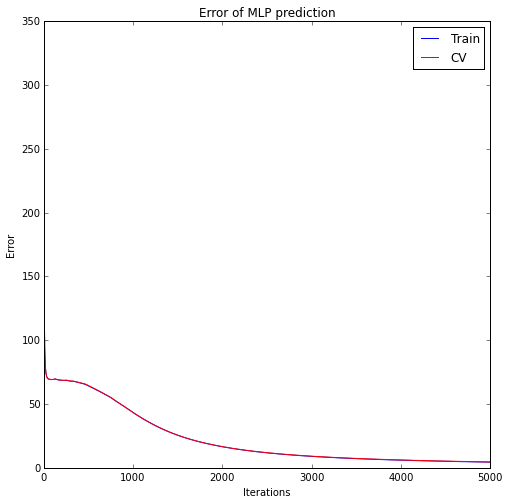

In [6]:
pl.figure(figsize=(8, 8))

N = len(mlp.train_loss)
t = np.linspace(1, N, N, endpoint=True)

train_loss, = pl.plot(t, mlp.train_loss, color='blue')
cv_loss, = pl.plot(t, mlp.cv_loss, color='red')
pl.title('Error of MLP prediction')
pl.legend([train_loss, cv_loss], ['Train', 'CV'])
pl.xlabel('Iterations')
pl.ylabel('Error')
pl.xlim(1, N)

pl.show()

In [7]:
#print 'True\tPredicted label'
count = 0
for i, y in enumerate(Y_test):
    y_true = np.argmax(y)
    y_pred = np.argmax(Y_pred[i])
    if y_true == y_pred:
        count += 1
    #print '%d\t%d' % (y_true, y_pred)
print '%0.1f%% correct labels' % (float(count) / len(Y_test) * 100)

100.0% correct labels
